In this module we will implement image classification through Multilayer Perceptron.
Recall that a MLP - also known as a feed forward network, is multilayered. By the univeral approximation theorem: an MLP with single hidden layer can approximate any continuous function with arbitrary accuracy.

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import math
from torch import matmul
from torch.nn.init import xavier_uniform_

Load and normalizing the CIFAR10 training and test datasets using torchvision

In [2]:
# TAKEN FROM CONVNET IMPLEMENTATION

# define transformation operation for corpus
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download trainset, init dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# download testset, init dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# define possible classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 ## Our own implemented functions

In [3]:
#Xavier for weight initalization
#m and h are the layer size dimensions
def xavier(layer_size, next_layer_size, gain=1):
  return torch.Tensor(layer_size, next_layer_size).uniform_(-1,1)*math.sqrt(6./(next_layer_size + layer_size))
  # torch.Tensor(layer_size, next_layer_size).uniform_(-1/math.sqrt(layer_size), 1/math.sqrt(layer_size))
  # return 

In [4]:
#Minibatch SGD with momentum (lecture 7, slide 7.2)
def MinibatchSGD(X, y, lr=.01, eps=1e-2, bsize=4, beta=.99): 
  N,D = X.shape
  w = np.zeros(D)
  g = np.inf
  dw=0
  while np.linalg.norm(g) > eps:
    minibatch = np.random.randint(N, size=(bsize)) 
    g = gradient(X[minibatch,:], y[minibatch], w) 
    dw = (1-beta)*g + beta*dw
    w = w - lr*dw
  return w

In [5]:
def tanh(x):
  x_exp = 1 + torch.exp(-2 * x)
  frac = (2/ x_exp)
  return frac - 1

In [6]:
def tanh_deriv(x):
  tanh_x = tanh(x)
  tanh_sq = tanh_x * tanh_x
  return 1 - tanh_sq

In [7]:
# implement ReLU derivative
def relu_deriv(x):
  tens = torch.gt(x,0).float() #= 0 if torch.gt(0) else 1
  # print("tens shape:", tens.shape)
  return tens

In [8]:
#implement ReLU for middle layers, don't use sigmoid
def relu(x):
  relu_tensor = torch.clamp(x, min=0)
  return relu_tensor

In [9]:
#Softmax (for final layer)
def softmax(u):  # N x C
  # for i in range(u.shape[0]):
  #   u[i] = torch.add(u[i], -torch.max(u[i]))
  # maximum = torch.max(u)
  # u = torch.add(u, -maximum)
  means = torch.mean(u,1,keepdim=True)
  # u_exp = torch.exp(torch.clamp(u, min=torch.min(means), max=torch.max(means))) #[:, None])
  # print("u:", u)
  u_exp = torch.exp(u-means) #, min=torch.min(means), max=torch.max(means)))
  # print("u_exp:", u_exp)
  # print(u_exp.shape)
  u_exp_sum = torch.sum(u_exp, dim=1, keepdim=True)
  # print(denom.shape)
  # frac = u_exp / denom
  # for i in range(u_exp.shape[0]):
  #   u_exp[i] = torch.div(u_exp[i], denom[i])
  # frac = torch.div(u_exp, denom)
  # print(u_exp)
  frac = u_exp/u_exp_sum
  # print("frac:",frac)
  return frac

In [10]:
def error(pred, label):
  n_samples = label.shape[0]
  logp = - torch.log(pred[np.arange(n_samples), torch.max(label,0)[1]])
  loss = torch.sum(logp) / n_samples
  return loss

In [11]:
def cross_entropy(pred, labels):
  labels_onehot = labels_to_onehot(labels)
  n_samples = pred.shape[0]
  loss = 0
  for i in range(n_samples):
    for j in range(pred.shape[1]):
      y = labels_onehot[i][j]
      yhat = pred[i][j]
      try:
        if y == 1:
          loss += -math.log(yhat)
        else:
          loss += -math.log(1 - yhat)
      except ValueError:
        print("ValueError:", yhat)
  loss = loss / (n_samples * pred.shape[1])

  return loss

In [12]:
def delta_cross_entropy(inp, out):
  m = out.shape[0]
  grad = inp
  grad[range(m),out] -= 1
  grad = grad/m
  return grad

In [13]:
def labels_to_onehot(labels):
  onehot = torch.zeros([labels.shape[0],10], dtype=torch.int32).cuda()
  for i in range(labels.shape[0]):
    onehot[i][labels[i]] = 1
  # print(onehot)
  return onehot

In [14]:
def softmax_deriv(outputs, labels_onehot):
  return outputs - labels_onehot

In [15]:
def dropout(Wx, drop_probability):
  keep_probability  = 1 - drop_probability
  mask = torch.Tensor(Wx.shape).uniform_(0,1).cuda() < keep_probability
  if keep_probability > 0:
    scale = keep_probability
  else:
    scale = 0.0
  out = scale * (mask * Wx)
  return out

In [16]:
def loss(labels_onehot, outputs):
  loss = -torch.log(labels_onehot * outputs)
  loss = torch.sum(loss) / labels_onehot.shape[0]
  return loss

In [17]:
def clip_grad(grad, threshold):
  if threshold != None:
    grad = torch.clamp(grad, min=-threshold, max=threshold)
  return grad

### Add GPU as device

In [18]:
# define device as GPU (if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a Multi-Layer Perceptron


In [36]:
class own_MLP(nn.Module):

  def __init__(self,
               hidden_sizes,
               lr,
               grad_clip, 
               drop_wt=0,
               schedule=False):
    super(own_MLP, self).__init__()
    self.hidden_sizes = hidden_sizes
    self.lr = lr
    self.grad_clip = grad_clip
    self.drop_wt = drop_wt
    self.schedule = schedule
    self.lr_sched = 0.1

    # create weight tensors, init with xavier
    self.w1 = xavier(32*32*3, self.hidden_sizes[0]).cuda()
    self.w2 = xavier(self.hidden_sizes[0], self.hidden_sizes[1]).cuda()
    self.w3 = xavier(self.hidden_sizes[1], self.hidden_sizes[2]).cuda()
    self.w4 = xavier(self.hidden_sizes[2], 10).cuda()


  def forward(self, x):
    # do forward pass
    x = x.view(-1, 32*32*3)
    self.z1 = matmul(x, self.w1)
    self.a1 = relu(self.z1)
    self.z2 = matmul(self.a1, self.w2)
    self.a2 = relu(self.z2)
    self.z3 = matmul(self.a2, self.w3)
    self.a3 = relu(self.z3)
    self.z4 = matmul(self.a3, self.w4)
    self.a4 = softmax(self.z4)
    return self.a4

  def backprop(self, X, labels, outputs):
    if self.schedule:
      self.learning_rate = self.learning_rate * 0.8
    X = X.view(-1, 3*32*32)

    # calculate derivatives
    self.a4_delta = clip_grad(outputs - labels_to_onehot(labels), self.grad_clip)
    self.a3_delta = clip_grad(relu_deriv(self.a3) * matmul(self.a4_delta, self.w4.T), self.grad_clip)
    self.a2_delta = clip_grad(relu_deriv(self.a2) * matmul(self.a3_delta, self.w3.T), self.grad_clip)
    self.a1_delta = clip_grad(relu_deriv(self.a1) * matmul(self.a2_delta, self.w2.T), self.grad_clip)

    # update the weights
    self.w4 -= self.lr * matmul(self.a3.T, self.a4_delta)
    self.w3 -= self.lr * matmul(self.a2.T, self.a3_delta)
    self.w2 -= self.lr * matmul(self.a1.T, self.a2_delta)
    self.w1 -= self.lr * matmul(X.T, self.a1_delta)
    

In [37]:
class pytorch_MLP(nn.Module):

  def __init__(self,
               hidden_size):
    super(pytorch_MLP, self).__init__()
    self.hidden_size = hidden_size

    self.h1 = torch.nn.Linear(32*32*3, self.hidden_size)
    self.h2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
    self.h3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
    self.h4 = torch.nn.Linear(self.hidden_size, 10)

    self.relu = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax()

  def forward(self, x):
    x = x.view(-1, 32*32*3)
    x.to(device)
    x = self.relu(self.h1(x))
    x = self.relu(self.h2(x))
    x = self.relu(self.h3(x))
    x = self.softmax(self.h4(x))
    return x

In [38]:
## CURRENTLY UNUSABLE!!
#   (implement if have time, for more complex experiments)

class complex_MLP(nn.Module):
  def __init__(self,
               layer_size, 
               activation_funct):
    super(simple_MLP, self).__init__()
    self.layer_size = layer_size
    self.n_layers = len(layer_size)
    self.activation_funct = activation_funct

    for i in range(n_layers):
      if i == 0:
        pass

### Run Experiments

In [39]:
def run_experiment(hidden_list, NUM_EPOCHS, lr=0.0001, grad_clip=None, drop_wt=0):
  mlp = own_MLP(hidden_sizes=hidden_list, lr=lr, grad_clip=grad_clip, drop_wt=drop_wt)
  mlp.to(device)

  acc_dict = {}
  
  # TRAIN !
  for epoch in range(NUM_EPOCHS):
    acc_list = []
    # reset loss to 0 at start of each epoch
    running_loss = 0.0

    # iterate through the data
    for i, data in enumerate(trainloader, 0):
      # load inputs and labels from dataloader, put on GPU
      inputs, labels = data[0].to(device), data[1].to(device)
      
      # forward pass
      outputs = mlp(inputs)

      # calc loss based on the outputs and ground truth
      loss = cross_entropy(outputs, labels)
     
      # calc the gradients through the network, update weights
      mlp.backprop(inputs, labels, outputs)
      
      running_loss += loss #.item()
      # every 2000 steps, print average loss and zero out running loss
      if i % 2000 == 1999:
        print('[%d, %5d] loss: %.3f' %
                  (epoch +1, i+1, running_loss / 2000))
        running_loss = 0.0
    
    # UPDATE LEARNING RATE 
    mlp.lr = mlp.lr_sched * mlp.lr
    
    correct = 0
    total = 0
    # don't update gradients (leftover from pytorch implementation, does nothing now)
    with torch.no_grad():
      # iterate through test dataset
      for data in trainloader:
        # load test data, put on GPU
        images, labels = data[0].to(device), data[1].to(device)
        # get outputs
        outputs = mlp(images)
        # predict category based on outputs
        _, predicted = torch.max(outputs.data, 1)
        # increase total number of labels by number of instances seen in this batch
        total += labels.size(0)
        # increase number of correct predicitons by number of correct predictions in this batch
        correct += (predicted == labels).sum().item()
    # calc and print overall model accuracy
    acc = 100 * correct / total
    acc_list.append(acc)
    print('Accuracy of the network on train images: %f %%' % (acc))
  
    correct = 0
    total = 0
    # don't update gradients
    with torch.no_grad():
      # iterate through test dataset
      for data in testloader:
        # load test data, put on GPU
        images, labels = data[0].to(device), data[1].to(device)
        # get outputs
        outputs = mlp(images)
        # predict category based on outputs
        _, predicted = torch.max(outputs.data, 1)

        # increase total number of labels by number of instances seen in this batch
        total += labels.size(0)
        # increase number of correct predicitons by number of correct predictions in this batch
        correct += (predicted == labels).sum().item()
    # calc and print overall model accuracy
    acc = 100 * correct / total
    acc_list.append(acc)
    print('Accuracy of the network on test images: %f %%' % (acc))

    acc_dict[epoch] = acc_list
  print('Finished Training!')

  # PREDICT AND CALCULATE ACCURACY
  # count number of correct and number of total
  correct = 0
  total = 0
  # don't update gradients
  with torch.no_grad():
    # iterate through test dataset
    for data in testloader:
      # load test data, put on GPU
      images, labels = data[0].to(device), data[1].to(device)
      # get outputs
      outputs = mlp(images)
      # predict category based on outputs
      _, predicted = torch.max(outputs.data, 1)
      # increase total number of labels by number of instances seen in this batch
      total += labels.size(0)
      # increase number of correct predicitons by number of correct predictions in this batch
      correct += (predicted == labels).sum().item()
  # calc and print overall model accuracy
  acc = 100 * correct / total
  print('Accuracy of the network on the 10000 test images: %f %%' % (acc))
  return acc_dict

In [40]:
acc_dict = run_experiment([1024, 512, 128], 20, lr=0.001, grad_clip=1, drop_wt=0)

[1,  2000] loss: 0.273
[1,  4000] loss: 0.251
[1,  6000] loss: 0.243
[1,  8000] loss: 0.239
[1, 10000] loss: 0.234
[1, 12000] loss: 0.231
Accuracy of the network on train images: 50.626000 %
Accuracy of the network on test images: 47.870000 %
[2,  2000] loss: 0.213
[2,  4000] loss: 0.208
[2,  6000] loss: 0.206
[2,  8000] loss: 0.202
[2, 10000] loss: 0.203
[2, 12000] loss: 0.201
Accuracy of the network on train images: 55.818000 %
Accuracy of the network on test images: 51.810000 %
[3,  2000] loss: 0.197
[3,  4000] loss: 0.198
[3,  6000] loss: 0.198
[3,  8000] loss: 0.197
[3, 10000] loss: 0.197
[3, 12000] loss: 0.195
Accuracy of the network on train images: 56.332000 %
Accuracy of the network on test images: 52.000000 %
[4,  2000] loss: 0.197
[4,  4000] loss: 0.196
[4,  6000] loss: 0.195
[4,  8000] loss: 0.196
[4, 10000] loss: 0.197
[4, 12000] loss: 0.196
Accuracy of the network on train images: 56.332000 %
Accuracy of the network on test images: 52.030000 %
[5,  2000] loss: 0.194
[5,  

In [41]:
print(acc_dict)

{0: [50.626, 47.87], 1: [55.818, 51.81], 2: [56.332, 52.0], 3: [56.332, 52.03], 4: [56.328, 52.04], 5: [56.328, 52.04], 6: [56.328, 52.04], 7: [56.328, 52.04], 8: [56.328, 52.04], 9: [56.328, 52.04], 10: [56.328, 52.04], 11: [56.328, 52.04], 12: [56.328, 52.04], 13: [56.328, 52.04], 14: [56.328, 52.04], 15: [56.328, 52.04], 16: [56.328, 52.04], 17: [56.328, 52.04], 18: [56.328, 52.04], 19: [56.328, 52.04]}


[1024, 512, 128], NUM_EPOCHS=40, lr=0.001, grad_clip=1, drop_wt=0)
{0: [50.626, 47.87], 1: [55.818, 51.81], 2: [56.332, 52.0], 3: [56.332, 52.03], 4: [56.328, 52.04], 5: [56.328, 52.04], 6: [56.328, 52.04], 7: [56.328, 52.04], 8: [56.328, 52.04], 9: [56.328, 52.04], 10: [56.328, 52.04], 11: [56.328, 52.04], 12: [56.328, 52.04], 13: [56.328, 52.04], 14: [56.328, 52.04], 15: [56.328, 52.04], 16: [56.328, 52.04], 17: [56.328, 52.04], 18: [56.328, 52.04], 19: [56.328, 52.04]}


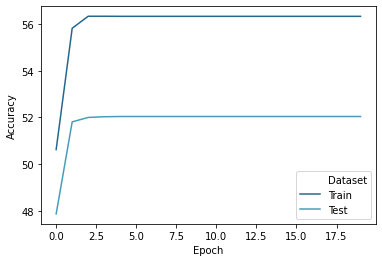

In [42]:
# code for graphing epochs vs acc for train vs. test
import seaborn as sns

datalist = []

for key in acc_dict.keys():
  currlist_train = [key, acc_dict[key][0], 'Train']
  datalist.append(currlist_train)
  currlist_test = [key, acc_dict[key][1], 'Test']
  datalist.append(currlist_test)

acc_df = pd.DataFrame(datalist, columns=['Epoch', 'Accuracy', 'Dataset'])
model_spec = "[1024, 512, 128], NUM_EPOCHS=40, lr=0.001, grad_clip=1, drop_wt=0)"
print(model_spec)
print(acc_dict)

g = sns.lineplot(x="Epoch", y="Accuracy", hue="Dataset", palette="YlGnBu_d", data=acc_df)

In [ ]:
acc_dict = run_experiment([1024, 512, 128], 120, lr=0.001, grad_clip=500, drop_wt=0)

[1,  2000] loss: 0.262
[1,  4000] loss: 0.241
[1,  6000] loss: 0.235
Accuracy of the network on train images: 50.628000 %
Accuracy of the network on test images: 47.860000 %
[2,  2000] loss: 0.217
[2,  4000] loss: 0.214
[2,  6000] loss: 0.213
Accuracy of the network on train images: 56.872000 %
Accuracy of the network on test images: 50.530000 %
[3,  2000] loss: 0.198
[3,  4000] loss: 0.198
[3,  6000] loss: 0.197
Accuracy of the network on train images: 61.744000 %
Accuracy of the network on test images: 52.750000 %
[4,  2000] loss: 0.180
[4,  4000] loss: 0.183
[4,  6000] loss: 0.184
Accuracy of the network on train images: 62.456000 %
Accuracy of the network on test images: 50.990000 %
[5,  2000] loss: 0.163
[5,  4000] loss: 0.169
[5,  6000] loss: 0.172
Accuracy of the network on train images: 69.150000 %
Accuracy of the network on test images: 53.910000 %
[6,  2000] loss: 0.151
[6,  4000] loss: 0.156
[6,  6000] loss: 0.158
Accuracy of the network on train images: 71.868000 %
Accuracy

KeyboardInterrupt: ignored

In [ ]:
run_experiment([1024, 128], 10, lr=0.0001, grad_clip=1, drop_wt=0.1)

[1,  2000] loss: 0.302
[1,  4000] loss: 0.279
[1,  6000] loss: 0.267
[1,  8000] loss: 0.262
[1, 10000] loss: 0.257
[1, 12000] loss: 0.257
Accuracy of the network on train images: 42 %
Accuracy of the network on test images: 41 %
[2,  2000] loss: 0.244
[2,  4000] loss: 0.247
[2,  6000] loss: 0.241
[2,  8000] loss: 0.243
[2, 10000] loss: 0.241
[2, 12000] loss: 0.239
Accuracy of the network on train images: 46 %
Accuracy of the network on test images: 44 %
[3,  2000] loss: 0.234
[3,  4000] loss: 0.233
[3,  6000] loss: 0.231
[3,  8000] loss: 0.230
[3, 10000] loss: 0.230
[3, 12000] loss: 0.230
Accuracy of the network on train images: 49 %
Accuracy of the network on test images: 47 %
[4,  2000] loss: 0.223
[4,  4000] loss: 0.225
[4,  6000] loss: 0.225
[4,  8000] loss: 0.223
[4, 10000] loss: 0.224
[4, 12000] loss: 0.221
Accuracy of the network on train images: 51 %
Accuracy of the network on test images: 47 %
[5,  2000] loss: 0.217
[5,  4000] loss: 0.216
[5,  6000] loss: 0.218
[5,  8000] loss

In [ ]:
run_experiment([1024, 128], NUM_EPOCHS=20, lr = 0.001, grad_clip=1, drop_wt=0.1)

[1,  2000] loss: 0.270
[1,  4000] loss: 0.252
[1,  6000] loss: 0.242
[1,  8000] loss: 0.241
[1, 10000] loss: 0.234
[1, 12000] loss: 0.229
Accuracy of the network on train images: 49 %
Accuracy of the network on test images: 47 %
[2,  2000] loss: 0.214
[2,  4000] loss: 0.215
[2,  6000] loss: 0.214
[2,  8000] loss: 0.214
[2, 10000] loss: 0.216
[2, 12000] loss: 0.213
Accuracy of the network on train images: 56 %
Accuracy of the network on test images: 50 %
[3,  2000] loss: 0.200
[3,  4000] loss: 0.199
[3,  6000] loss: 0.196
[3,  8000] loss: 0.198
[3, 10000] loss: 0.200
[3, 12000] loss: 0.196
Accuracy of the network on train images: 60 %
Accuracy of the network on test images: 51 %
[4,  2000] loss: 0.185
[4,  4000] loss: 0.184
[4,  6000] loss: 0.184
[4,  8000] loss: 0.185
[4, 10000] loss: 0.185
[4, 12000] loss: 0.185
Accuracy of the network on train images: 63 %
Accuracy of the network on test images: 53 %
[5,  2000] loss: 0.168
[5,  4000] loss: 0.171
[5,  6000] loss: 0.173
[5,  8000] loss

In [ ]:
run_experiment([1024, 512, 128], NUM_EPOCHS=20, lr = 0.001, grad_clip=1, drop_wt=0.1)

[1,  2000] loss: 0.275
[1,  4000] loss: 0.251
[1,  6000] loss: 0.242
[1,  8000] loss: 0.242
[1, 10000] loss: 0.235
[1, 12000] loss: 0.232
Accuracy of the network on train images: 50 %
Accuracy of the network on test images: 47 %
[2,  2000] loss: 0.213
[2,  4000] loss: 0.216
[2,  6000] loss: 0.215
[2,  8000] loss: 0.217
[2, 10000] loss: 0.213
[2, 12000] loss: 0.213
Accuracy of the network on train images: 56 %
Accuracy of the network on test images: 50 %
[3,  2000] loss: 0.196
[3,  4000] loss: 0.195
[3,  6000] loss: 0.198
[3,  8000] loss: 0.196
[3, 10000] loss: 0.199
[3, 12000] loss: 0.198
Accuracy of the network on train images: 60 %
Accuracy of the network on test images: 51 %
[4,  2000] loss: 0.179
[4,  4000] loss: 0.181
[4,  6000] loss: 0.183
[4,  8000] loss: 0.181
[4, 10000] loss: 0.185
[4, 12000] loss: 0.185
Accuracy of the network on train images: 62 %
Accuracy of the network on test images: 50 %
[5,  2000] loss: 0.165
[5,  4000] loss: 0.164
[5,  6000] loss: 0.169
[5,  8000] loss

In [ ]:
print(acc_dict)

NameError: ignored